# Simple Recurrent Network (SRN, Elman 1990) applied to sMNIST
## This code uses flax.linen.scan to speed up the loop over time

## Equations
State update:

$
\vec{h}_t = \tanh(W_{hx}\vec{x}_t + W_{hh}\vec{h}_{t-1} + \vec{b}_h) \text{ with }\vec{h}_t \in \mathbb{R}^{n_h} \text{ and } \vec{x}_t \in \mathbb{R}^{n_x}
$

Output: mean of output over time (or cummulative sum of output over time):

$
\vec{o}_t = W_{hy}\vec{h}_t + \vec{b}_o \\
\vec{o} = \frac{1}{T}\sum_{t=1}^{T}\vec{o}_t \\
\vec{y} = \text{softmax}(\vec{o}) \\
$

In [1]:
!pwd
!which python
!pip freeze | grep -E 'flax|jax|orbax|optax'

/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/home/tristan/LearningJAX/Flax
/home/tristan/miniconda3/envs/.jax_conda_env_LearningJAX/bin/python
flax==0.8.0
jax==0.4.25
jaxlib==0.4.25+cuda11.cudnn86
optax==0.1.8
orbax-checkpoint==0.5.0


In [1]:
import jax
import numpy as np
import torch
from jax import numpy as jnp
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from flax import linen as nn
from flax.training import train_state
import optax
from jax.nn.initializers import lecun_normal
from typing import Any, Tuple, Sequence, Optional
import matplotlib.pyplot as plt
px = 1 / plt.rcParams['figure.dpi']

jnp.set_printoptions(precision=3, suppress=True)

# set cuda visible devices
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from utils import create_mnist_classification_dataset, plot_dynamics

In [3]:
DATASET_VERSION = 'row'
trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data", version=DATASET_VERSION)

[*] Generating MNIST Classification Dataset...


In [4]:
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)
print(batch_y.dtype)

(128, 28, 28) (128,)
int64


In [5]:
from typing import Sequence

class RNNCell(nn.Module):
    @nn.compact
    def __call__(self, state, x):
        # Wh @ h + Wx @ x + b can be efficiently computed
        # by concatenating the vectors and then having a single dense layer
        x = jnp.concatenate([state, x])
        new_state = jnp.tanh(nn.Dense(state.shape[0], name='Dense_RNN')(x))
        out = jnp.tanh(nn.Dense(10, name='Dense_Out')(new_state))
        return new_state, (new_state, out)
    
class RNNLayer(nn.Module):
    hidden_size: int

    @nn.compact
    def __call__(self, x):
        scan_RNNCell = nn.scan(
            RNNCell,
            variable_broadcast='params',
            split_rngs={'params': False},
            in_axes=0,
            out_axes=0,
        )
        rnn_cell = scan_RNNCell()
        state = jnp.zeros((self.hidden_size,))
        _, (state_hist, out_hist) = rnn_cell(state, x)
        return state_hist, out_hist

class RNN(nn.Module):
    hidden_size: int
    output_size: int

    @nn.compact
    def __call__(self, x):
        rnn_cell = RNNLayer(self.hidden_size)
        # print(x.shape)
        state_hist, out_hist = rnn_cell(x)
        return [state_hist], out_hist
    
BatchRNN = nn.vmap(RNN, in_axes=0, out_axes=0, variable_axes={'params': None}, split_rngs={'params': False})


In [6]:
srn = BatchRNN(256, 10)
params = srn.init(jax.random.PRNGKey(0), jnp.zeros_like(batch_x[:5]))
state_hist, out_hist = srn.apply(params, batch_x[:5])
print(len(state_hist), state_hist[0].shape, out_hist.shape) # (batch, time, cell_size)
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)

1 (5, 28, 256) (5, 28, 10)
(5, 10)
[[ 0.428 -0.064 -0.458  0.3   -0.041  0.232  0.424 -0.262 -0.669 -0.024]
 [ 0.429 -0.131 -0.363  0.29   0.098  0.348  0.362 -0.095 -0.65   0.036]
 [ 0.442 -0.147 -0.481  0.277 -0.061  0.321  0.439 -0.238 -0.698 -0.013]
 [ 0.383  0.071 -0.269  0.328  0.099  0.235  0.306 -0.171 -0.626 -0.004]
 [ 0.449  0.008 -0.415  0.352 -0.085  0.217  0.368 -0.273 -0.68   0.076]]


In [7]:
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())


(5,)
[2.609 2.749 2.498 1.996 2.447]
2.4598565


In [8]:
print(params['params'].keys())
print(params['params']['RNNLayer_0'].keys())
print(params['params']['RNNLayer_0']['ScanRNNCell_0'].keys())

print('\nparams: \n', jax.tree_util.tree_map(jnp.shape, params['params']))

# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_Out']['kernel'].shape == (256, 10)
# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_Out']['bias'].shape == (10,)
# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_RNN']['kernel'].shape == (257, 256)
# assert params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_RNN']['bias'].shape == (256,)

dict_keys(['RNNLayer_0'])
dict_keys(['ScanRNNCell_0'])
dict_keys(['Dense_Out', 'Dense_RNN'])

params: 
 {'RNNLayer_0': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (284, 256)}}}}


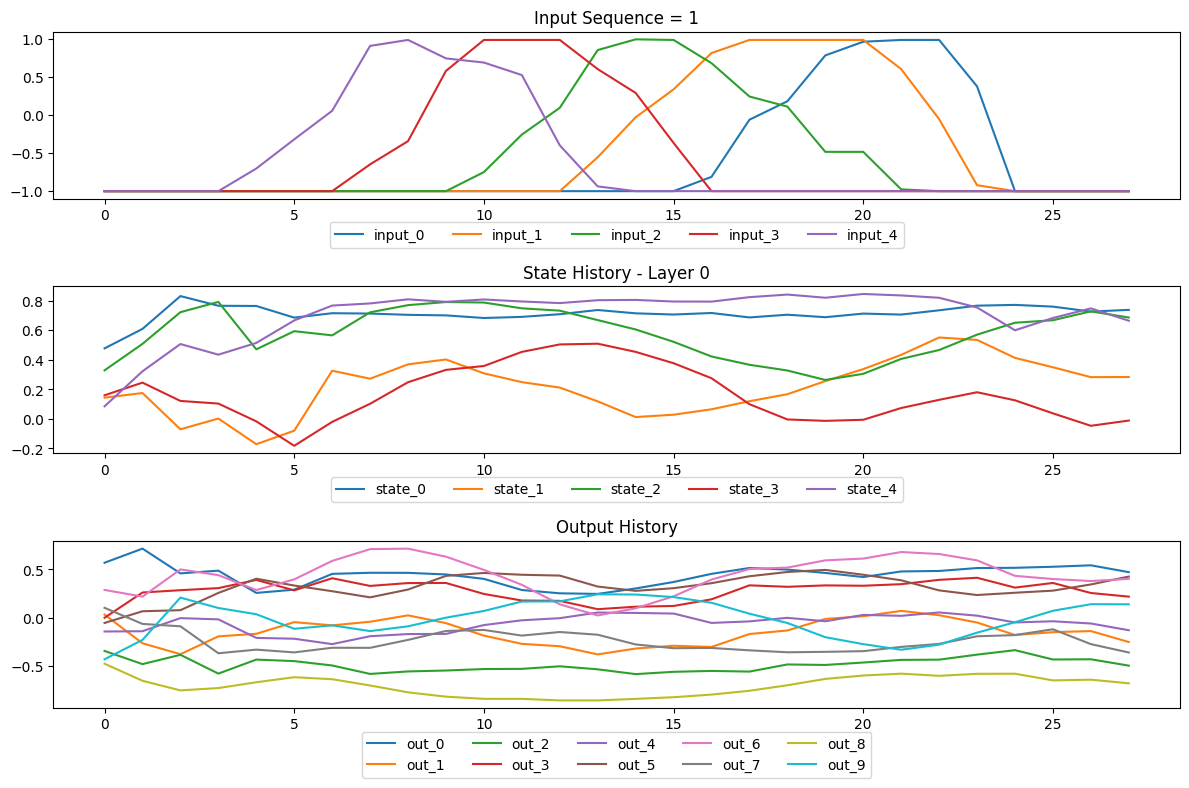

In [10]:
plot_dynamics(srn, params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=2)

In [19]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)
lr = 1e-3

In [20]:
@jax.jit
def update_model(state, grads):
    return state.apply_gradients(grads=grads)

In [21]:
def apply_model(state, images, labels):
    """Computes gradients, loss and accuracy for a single batch."""

    def loss_fn(params):
        _, out_hist = state.apply_fn({'params': params}, images)
        logits = out_hist.mean(axis=1)
        one_hot = jax.nn.one_hot(labels, 10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return grads, loss, accuracy
    

In [22]:
def run_epoch(state, train_dl, rng):
    """Train for a single epoch."""

    epoch_loss = []
    epoch_accuracy = []

    progress_bar = tqdm(train_dl, desc="Training", leave=True)
    batch_id = 0
    for batch_images, batch_labels in progress_bar:
        grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
        # print(jnp.max(grads['dense_0']['kernel']), jnp.min(grads['dense_0']['kernel']))
        # print(loss)
        state = update_model(state, grads)
        epoch_loss.append(loss)
        epoch_accuracy.append(accuracy)
        batch_id += 1
        if batch_id % 3 == 0:
            progress_bar.set_postfix(loss=loss.item(), accuracy=accuracy.item())
        
    train_loss = np.mean(epoch_loss)
    train_accuracy = np.mean(epoch_accuracy)
    return state, train_loss, train_accuracy


In [26]:
def create_train_state(key, model_cls, lr, dataset_version):
    
    init_x = jnp.ones((128, 784, 1)) if dataset_version == "sequential" else jnp.ones((128, 28, 28))

    model = model_cls(hidden_size=256, output_size=10)
    params = model.init(key, init_x)['params']
    
    # Debugging: Print parameter structure
    print("Initialized parameter structure:", jax.tree_util.tree_map(jnp.shape, params))

    optimizer = optax.adam(lr)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params,
        tx=optimizer,
    )


In [27]:
state = create_train_state(key, BatchRNN, lr, DATASET_VERSION)

Initialized parameter structure: {'RNNLayer_0': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (284, 256)}}}}


We can see that 1 epoch takes ~2min with this scan version.
The vanilla version takes ~2min for 10 batches --> 92 min / epoch.

In [29]:
for epoch in range(1):
    state, train_loss, train_accuracy = run_epoch(state, trainloader, key)
    print(f"Epoch {epoch} | Loss: {train_loss} | Accuracy: {train_accuracy}")

Training: 100%|██████████| 468/468 [03:25<00:00,  2.28it/s, accuracy=0.898, loss=1.25]

Epoch 0 | Loss: 1.279372215270996 | Accuracy: 0.8718449473381042


In [31]:
print(jax.tree_util.tree_map(jnp.shape, params['params']))
print(jax.tree_util.tree_map(jnp.shape, state.params))

{'RNNLayer_0': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (284, 256)}}}}
{'RNNLayer_0': {'ScanRNNCell_0': {'Dense_Out': {'bias': (10,), 'kernel': (256, 10)}, 'Dense_RNN': {'bias': (256,), 'kernel': (284, 256)}}}}


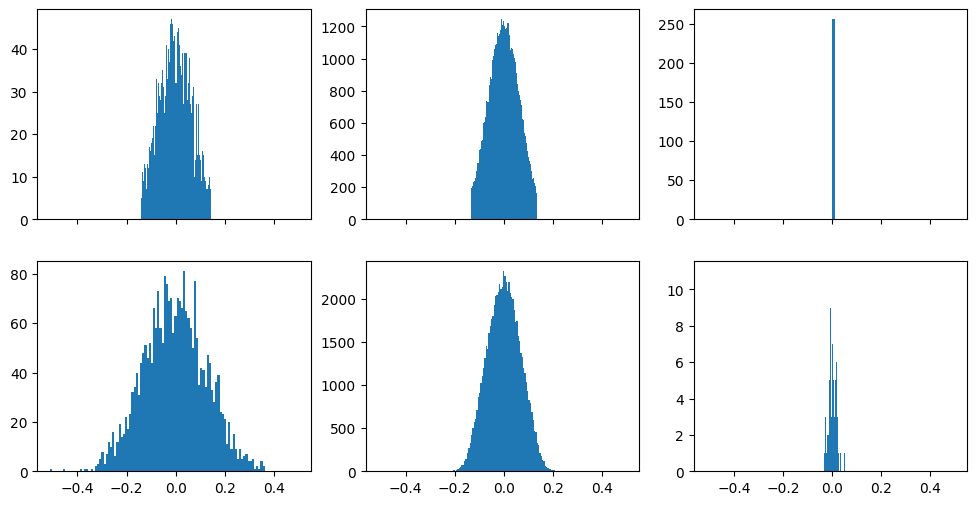

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(1200*px, 600*px), sharex=True)
axs[0,0].hist(params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_Out']['kernel'].flatten(), bins=100)
axs[0,1].hist(params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_RNN']['kernel'].flatten(), bins=100)
axs[0,2].hist(params['params']['RNNLayer_0']['ScanRNNCell_0']['Dense_RNN']['bias'].flatten(), bins=100)
axs[1,0].hist(state.params['RNNLayer_0']['ScanRNNCell_0']['Dense_Out']['kernel'].flatten(), bins=100)
axs[1,1].hist(state.params['RNNLayer_0']['ScanRNNCell_0']['Dense_RNN']['kernel'].flatten(), bins=100)
axs[1,2].hist(state.params['RNNLayer_0']['ScanRNNCell_0']['Dense_RNN']['bias'].flatten(), bins=100)
plt.show()

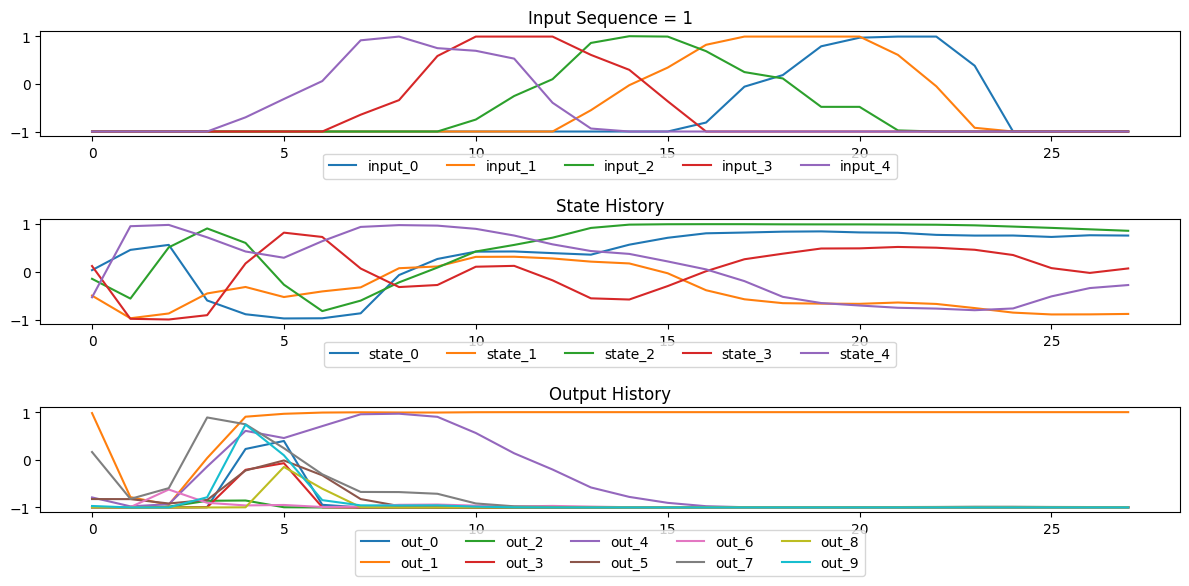

In [45]:
plot_dynamics(srn, state.params, batch_x, batch_y, dataset_version=DATASET_VERSION, id_sample=2)

In [ ]:
all_state_hist, out_hist = srn.apply({'params':state.params}, batch_x[:5])

In [ ]:
y = out_hist.mean(axis=1)
print(y.shape)
assert y.shape == (5, 10)
print(y)

(5, 10)
[[-0.786  0.392 -0.368 -1.198  0.262  1.9    0.436 -0.656  0.943  2.003]
 [-0.887 -0.137 -0.258 -1.159  0.678  2.152 -0.179 -0.587  0.68   2.073]
 [-0.537  0.661 -0.413 -1.569  0.141  1.845  0.58  -0.356  0.717  2.108]
 [-0.932 -0.104 -0.042 -0.866  0.268  2.164 -0.191 -1.35   0.661  1.894]
 [-1.342  0.216 -0.427 -0.609  0.241  2.619 -0.283 -1.123  0.982  1.888]]


In [ ]:
one_hot = jax.nn.one_hot(batch_y[:5], 10)
loss = optax.softmax_cross_entropy(logits=y, labels=one_hot)
print(loss.shape)
print(loss)
print(loss.mean())

(5,)
[3.79  3.447 2.502 4.039 3.093]
3.3741264
